In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torch.nn as nn
import torch

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
transform = {
        'train': transforms.Compose(
            [
             transforms.CenterCrop(224),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ]),
        'test': transforms.Compose(
            [transforms.CenterCrop(224),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
             ])}

data = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/dibas files', transform=transform['train'])
    

In [5]:
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(list(range(len(data.targets))), test_size=0.2, stratify=data.targets)
data_train = torch.utils.data.Subset(data, train_indices)
data_test = torch.utils.data.Subset(data, test_indices)

print ('train_dataset = ', len(data_train))
print ('test_dataset = ', len(data_test))
image, label = data_train[]
print (image.size())

train_dataset =  426
test_dataset =  107
torch.Size([3, 224, 224])


In [6]:
# set data loadser
train_loader = torch.utils.data.DataLoader(
      dataset=data_train,
      batch_size=1, 
      shuffle=True,
      )
 
test_loader = torch.utils.data.DataLoader(
      dataset=data_test,
      batch_size=1, 
      shuffle=False,
      )

In [7]:
class AlexNet(nn.Module):
 
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
 
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [8]:
# select device
num_classes = 26
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

In [18]:
!pip install madgrad

In [9]:
import madgrad

# MADGRAD optimizing
criterion = nn.CrossEntropyLoss()
optimizer = madgrad.MADGRAD(net.parameters(), lr=0.0002, momentum=0.5, weight_decay=5e-4)

In [59]:
# SGD optimizing
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [67]:
# ADAM optimizing
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
adam_optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [10]:
# training
num_epochs = 20
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
 
### training
for epoch in range(num_epochs):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ====== train_mode ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    
        # ====== val_mode ======
    net.eval()
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)
    
    print ('Epoch [{}/{}], Train Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/20], Train Loss: 3.2683, val_loss: 3.2576, val_acc: 0.0374
Epoch [2/20], Train Loss: 3.2641, val_loss: 3.2572, val_acc: 0.0467
Epoch [3/20], Train Loss: 3.2629, val_loss: 3.2566, val_acc: 0.0467
Epoch [4/20], Train Loss: 3.2627, val_loss: 3.2563, val_acc: 0.0467
Epoch [5/20], Train Loss: 3.2626, val_loss: 3.2562, val_acc: 0.0467
Epoch [6/20], Train Loss: 3.2625, val_loss: 3.2560, val_acc: 0.0467
Epoch [7/20], Train Loss: 3.2624, val_loss: 3.2558, val_acc: 0.0467
Epoch [8/20], Train Loss: 3.2622, val_loss: 3.2558, val_acc: 0.0467
Epoch [9/20], Train Loss: 3.2624, val_loss: 3.2558, val_acc: 0.0467
Epoch [10/20], Train Loss: 3.2624, val_loss: 3.2557, val_acc: 0.0467
Epoch [11/20], Train Loss: 3.2624, val_loss: 3.2557, val_acc: 0.0467
Epoch [12/20], Train Loss: 3.2623, val_loss: 3.2556, val_acc: 0.0467
Epoch [13/20], Train Loss: 3.2622, val_loss: 3.2556, val_acc: 0.0467
Epoch [14/20], Train Loss: 3.2623, val_loss: 3.2556, val_acc: 0.0467
Epoch [15/20], Train Loss: 3.2624, val_loss

Epoch [20/20], Loss: 0.5416, val_loss: 3.1894, val_acc: 0.0258


ValueError: ignored

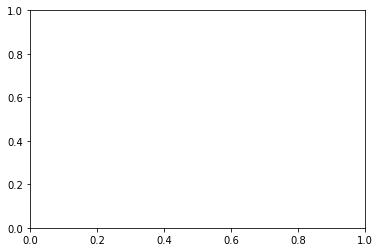

In [62]:
# plot graph
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
 
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
 